In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
# Loading the data
listings_dataframe = pd.read_csv("cleaned_listing_data.csv")
reviews_dataframe = pd.read_csv("reviews_summary.csv")

In [32]:
listings_dataframe.columns, reviews_dataframe.columns

(Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
        'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
        'minimum_nights', 'number_of_reviews', 'last_review',
        'reviews_per_month', 'calculated_host_listings_count',
        'availability_365', 'number_of_reviews_ltm', 'reviewed'],
       dtype='object'),
 Index(['listing_id', 'date'], dtype='object'))

In [33]:
listings_dataframe.shape

(39638, 18)

# Questions to answer
1. What factors significantly influence the price of Airbnb listing in NYC?
2. How does the availability of Airbnb listings vary across different neighborhoods in NYC?
3. What is the relationship between number of reviews a listing has and its price/availability?
4. Do hosts with multiple listings price their properties differently compared to hosts with only one listing?
5. What is the distribution of different room types in the listings? How does room type affect the price of the listings?
6. Can we build a model to predict the price of Airbnb listing based on its features?

## Distribution of price
First we will see how the distribution of price is

<Axes: xlabel='price', ylabel='Count'>

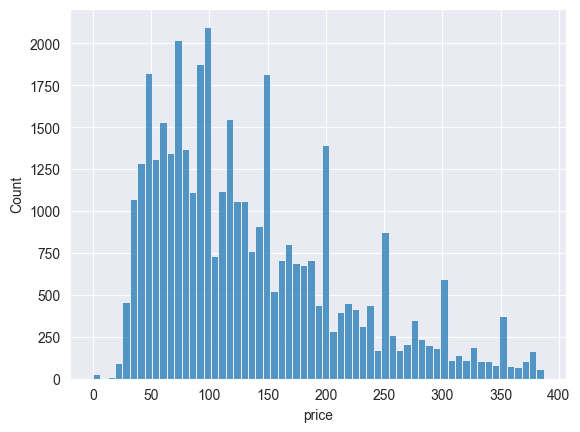

In [37]:
import numpy as np
sns.histplot(listings_dataframe,x='price')

<Axes: xlabel='price'>

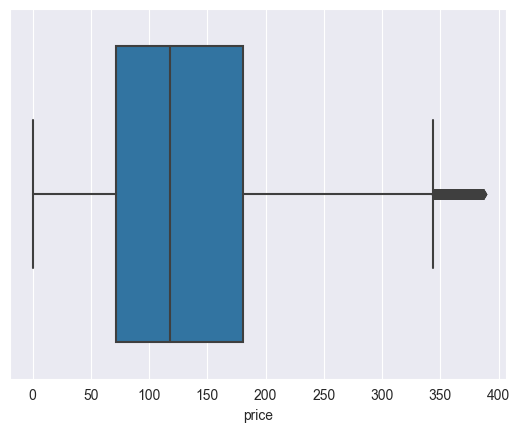

In [36]:
sns.boxplot(listings_dataframe,x="price")

There seems to be some right skewness in the dataset. But since the skewness isnt extreme, we dont necessarily need transformations.

## What factors significantly influence the price of Airbnb listing in NYC

Lets consider only the numerical variables first

<Axes: >

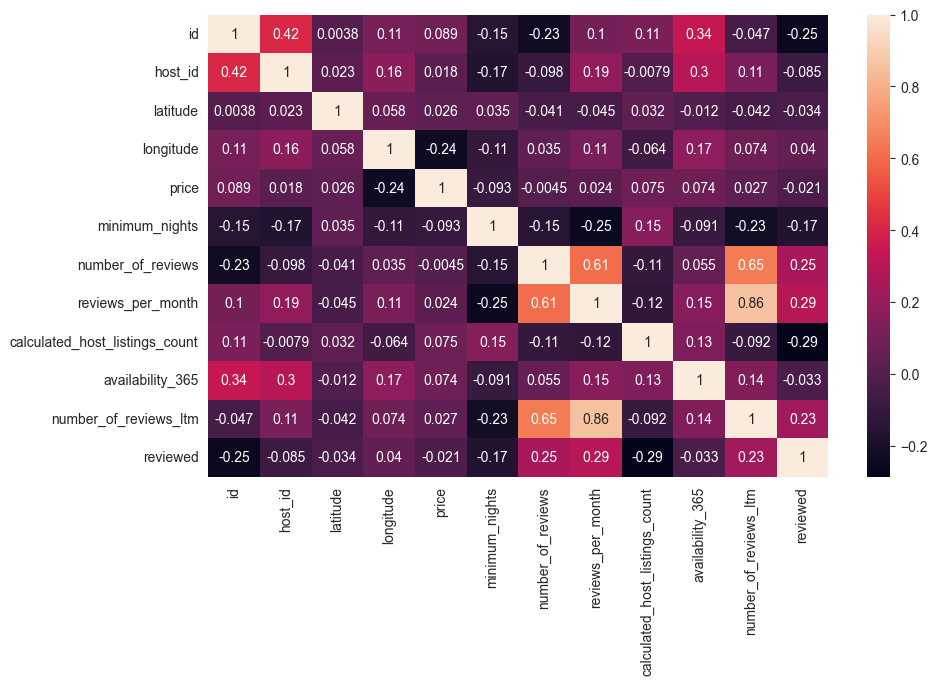

In [45]:
# selecting the numerical data
correlation_matrix = listings_dataframe.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True)

In [52]:
correlation_with_price = correlation_matrix['price'].apply(abs)
sorted_corr_with_price = correlation_with_price.sort_values(ascending=False)

In [53]:
sorted_corr_with_price

price                             1.000000
longitude                         0.240760
minimum_nights                    0.093471
id                                0.088602
calculated_host_listings_count    0.075157
availability_365                  0.074112
number_of_reviews_ltm             0.026832
latitude                          0.025522
reviews_per_month                 0.023771
reviewed                          0.020950
host_id                           0.017930
number_of_reviews                 0.004511
Name: price, dtype: float64

There doesnt seem to be direct linear relationship between price and other variables. Visualizations can be used to reveal other interesting patterns and relationships

Text(0, 0.5, 'Price')

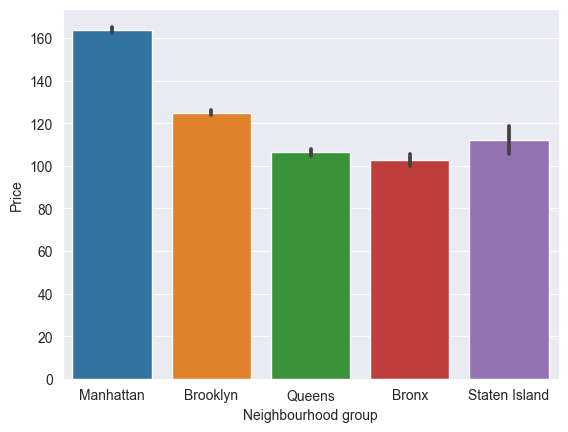

In [60]:
sns.barplot(listings_dataframe, x="neighbourhood_group", y="price")
plt.xlabel("Neighbourhood group")
plt.ylabel("Price")

From the barplot, it can be seen that the price in Manhattan area is significantly greater than other areas, so neighbourhood might be good feature to find out the price

Text(0, 0.5, 'Price')

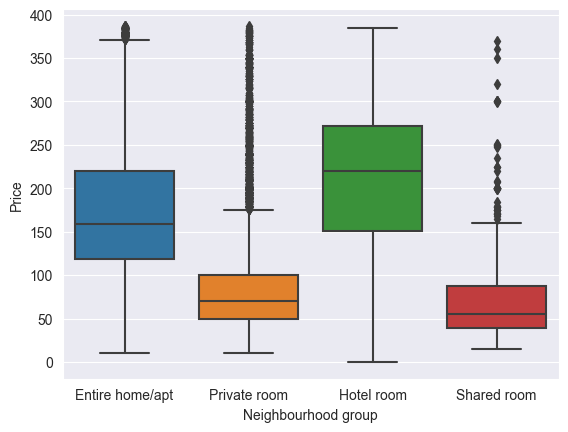

In [63]:
sns.boxplot(listings_dataframe, x="room_type", y="price")
plt.xlabel("Neighbourhood group")
plt.ylabel("Price")

The median prices for the room type are at different levels. This might help in finding the price of the listing. Thus, room_type can be considered a good factor for predicting price.

<Axes: xlabel='price', ylabel='availability_365'>

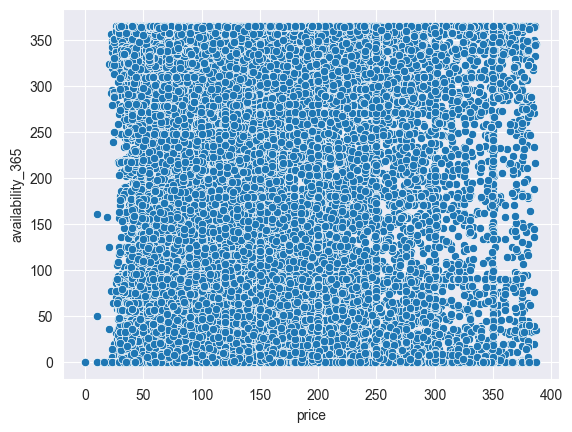

In [64]:
sns.scatterplot(listings_dataframe, x="price",y="availability_365")

The scatterplot have points scattered all across the plot, so there doesnt seem to be any specific relationship between price and availability.

<Axes: xlabel='calculated_host_listings_count', ylabel='price'>

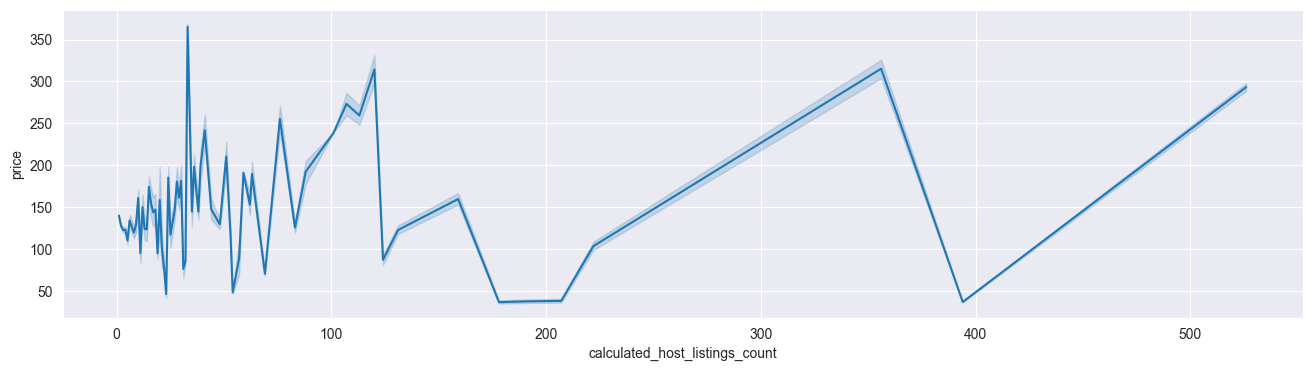

In [75]:
plt.figure(figsize=(16,4))
sns.lineplot(listings_dataframe, y="price",x="calculated_host_listings_count")

There seems to be some non-linear relationship between price and calculated_host_listings_count, so we might need to consider this variable to predict the price

From the above analysis, it can be noted that variables like calculated_host_listings_count, neighbourhood_group, room_type, etc. can be some factors that are important for pricing.

## How does the availability of Airbnb listings vary across different neighborhoods in NYC?